# Lab 1: Keras and MNIST

**This is a modified version of the original notebook by Francois Chollet.** 

We will now take a look at a first concrete example of a neural network, which makes use of the Python library Keras to learn to classify hand-written digits. Unless you already have experience with Keras or similar libraries, you will not understand everything about this first example right away. Don't worry, that is perfectly fine. We've got to start somewhere.

The problem we are trying to solve here is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 categories (0 to 9). The dataset we will use is the MNIST dataset, a classic dataset in the machine learning community, which has been around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. You can think of "solving" MNIST as the "Hello World" of deep learning -- it's what you do to verify that your algorithms are working as expected. As you become a machine learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on. 

The MNIST dataset comes pre-loaded in Keras, in the form of a set of four Numpy arrays:

In [1]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

`train_images` and `train_labels` form the "training set", the data that the model will learn from. The model will then be tested on the 
"test set", `test_images` and `test_labels`. Our images are encoded as Numpy arrays, and the labels are simply an array of digits, ranging 
from 0 to 9. There is a one-to-one correspondence between the images and the labels.

Let's have a look at the training data:

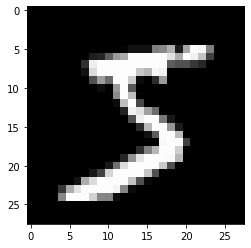

In [2]:
import matplotlib.pyplot as plt

plt.imshow(train_images[0], cmap='gray')

In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
train_images[0] # the first image

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [5]:
train_images[0].shape  # the shape of the first image

(28, 28)

In [6]:
len(train_labels)

60000

In [7]:
train_labels[:6] # first 5 labels

array([5, 0, 4, 1, 9, 2], dtype=uint8)

Let's have a look at the test data:

In [8]:
test_images.shape

(10000, 28, 28)

In [9]:
len(test_labels)

10000

In [10]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)


Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in 
the `[0, 1]` interval. Previously, our training images for instance were stored in an array of shape `(60000, 28, 28)` of type `uint8` with 
values in the `[0, 255]` interval. We transform it into a `float32` array of shape `(60000, 28 * 28)` with values between 0 and 1.

In [11]:
train_images = train_images.astype('float32') / 255
train_images = train_images.reshape((60000, 28 * 28))

test_images = test_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))

### Reshaping an image for the network

The picture below shows the steps involved in converting a 10x10 pixel image into a 1 dimensional array that can be fed into a fully-connected neural network (assuming we do not scale the pixel values). 

<img src="Lab 1 - Pictures-2.jpg" width=600 align="center">

And the picture below should help you visualize what things look like when we consider more than a single sample in our data:

<img src="Lab 1 - Pictures-3.jpg" width=600 align="center">

We also need to categorically encode the labels:

In [12]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [13]:
train_labels[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

<img src="Lab 1 - Pictures-5.jpg" width=600 align="center">

Our workflow will be as follow: first we will present our neural network with the training data: `train_images` and `train_labels`. The 
network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_images`, and we 
will verify if these predictions match the labels from `test_labels`.

## Build the network

Let's build our network!

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

network = Sequential()
network.add(Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(Dense(10, activation='softmax'))

The core building block of neural networks is the "layer", a data-processing module which you can conceive as a "filter" for data. Some data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them -- hopefully representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a 
succession of increasingly refined data filters -- the "layers".

Here our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each score will be the probability that the current digit image belongs to one of our 10 digit classes. See this [blog post](https://victorzhou.com/blog/softmax/) for more details on the softmax function. The following picture may help you see what is happening:

<img src="Lab 1 - Pictures-4.jpg" width=600 align="center">

## Network architecture and parameters
It is often helpful to review the architecture of the network and see how many parameters will need to be learned through the training process. To do this, Keras provides the `.summary()` function:

In [15]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


## Compile the network
To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: this is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update its parameters (weights and biases) based on the data it sees and its loss function. This is like the *gradient descent* recipe for updating the network's parameters.
* Metrics: what to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [16]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data.

## Train the network

In [17]:
history = network.fit(train_images, train_labels, epochs=5, batch_size=128, verbose=1)

Epoch 1/5
469/469 [==============================] - 2s 5ms/step - loss: 0.2573 - accuracy: 0.9265
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 0.1020 - accuracy: 0.9698
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0666 - accuracy: 0.9800
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0484 - accuracy: 0.9850
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0360 - accuracy: 0.9891


Two quantities are being displayed during training: the "loss" of the network over the training data, and the accuracy of the network over 
the training data.

We quickly reach an accuracy of around 0.98 (i.e. 98%) on the training data. 

## Check test accuracy

Now let's check that our model performs well on the test set too:

In [18]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.0707 - accuracy: 0.9789


In [19]:
print('test_acc:', test_acc)

test_acc: 0.9789000153541565



Our test set accuracy turns out to be around 98%, which is lower than the training set accuracy. 
This concludes our very first example -- you just saw how we could build and train a neural network to classify handwritten digits, in less than 20 lines of Python code. 

**epoch** 
  - one epoch is reached when all training examples have been sent through the network
  
**batch size**
  - the training data is not sent through the network one sample at time but in batches; this is another hyperparamter to be set. The weights and biases are updated after each batch is processed by the network. In this example the batch size was set to 128


## Your turn

Rerunning the network means executing the following steps:
- Build the network
- Network architecure and parameters
- Compile the network
- Train the network
- Check test accuracy

**Each exercise will thus have all the necessary code to build, compile, fit, and test.**

## Starting Code

Begin with the following code for Exercises 1 to 5, that is, the code below is what you are being asked to modify in the first five exercises:

```
network = Sequential()
network.add(Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(Dense(10, activation='softmax'))

network.summary()

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
                
network.fit(train_images, train_labels, epochs=5, batch_size=128, verbose=1)

test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)
```

Be sure to rename the `network` for each Exercise. 

### Exercise 1 (5 marks)

- change the activation in the hidden layer to 'sigmoid'
- run the modified code
- record the results in the **Aggregated Results** section below

In [20]:
network1 = Sequential()
network1.add(Dense(512, activation='sigmoid', input_shape=(28 * 28,)))
network1.add(Dense(10, activation='softmax'))

network1.summary()

network1.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

network1.fit(train_images, train_labels, epochs=5, batch_size=128, verbose=1)

test_loss, test_acc = network1.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 0.4231 - accuracy: 0.8847
Epoch 2/5
469/469 [==============================] - 3s 5ms/step - loss: 0.2346 - accuracy: 0.9317
Epoch 3/5
469/469 [==============================] - 3s 5ms/step - loss: 0.1773 - accuracy: 0.9481
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.1385 - accuracy: 0.9588
Epoch 5/5
313/313 [=============================

### Exercise 2 (5 marks)

- change the batch size to 32
- run the modified code
- record the results in the **Aggregated Results** section below

In [21]:
network = Sequential()
network.add(Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(Dense(10, activation='softmax'))

network.summary()

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

network.fit(train_images, train_labels, epochs=10, batch_size=32, verbose=1)

test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2017 - accuracy: 0.9406
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0886 - accuracy: 0.9745
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0660 - accuracy: 0.9813
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0513 - accuracy: 0.9862
Epoch 5/10
1875/1875 [==============

### Exercise 3 (5 marks)

- change the number of epochs to 10
- run the modified code
- record the results in the **Aggregated Results** section below

In [22]:
network = Sequential()
network.add(Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(Dense(10, activation='softmax'))

network.summary()

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

network.fit(train_images, train_labels, epochs=10, batch_size=128, verbose=1)

test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2556 - accuracy: 0.9255
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1023 - accuracy: 0.9700
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0682 - accuracy: 0.9792
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0487 - accuracy: 0.9858
Epoch 5/10
469/469 [========================

### Exercise 4 (5 marks)

- change the number of neurons in the hidden layer to 128
- run the modified code
- record the results in the **Aggregated Results** section below

In [23]:
network = Sequential()
network.add(Dense(128, activation='relu', input_shape=(28 * 28,)))
network.add(Dense(10, activation='softmax'))

network.summary()

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

network.fit(train_images, train_labels, epochs=5, batch_size=128, verbose=1)

test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               100480    
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
469/469 [==============================] - 1s 2ms/step - loss: 0.3317 - accuracy: 0.9094
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1567 - accuracy: 0.9553
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1123 - accuracy: 0.9666
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0875 - accuracy: 0.9743
Epoch 5/5
313/313 [=============================

### Exercise 5 (10 marks)

- add a second hidden layer of 128 neurons (note that `input_shape` does not need to be set for a second *Dense* layer)
- run the modified code
- record the results in the **Aggregated Results** section below

In [24]:
network = Sequential()
network.add(Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(Dense(128, activation='relu'))
network.add(Dense(10, activation='softmax'))

network.summary()

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

network.fit(train_images, train_labels, epochs=5, batch_size=128, verbose=1)

test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               401920    
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dense_12 (Dense)            (None, 10)                1290      
                                                                 
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 0.2357 - accuracy: 0.9285
Epoch 2/5
469/469 [==============================] - 3s 5ms/step - loss: 0.0867 - accuracy: 0.9736
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0561 - accuracy: 0.9823
Epoch 4/5
469/4

### Exercise 6 (10 marks)

There is a good chance that the network from the previous exercise is overfitting. One way to manage overfitting in a network is to add a **dropout** layer. A dropout layer will randomly "turn off" (or *drop*) a fraction of the neurons in a layer. This makes it harder for the network to 'memorize' the training data. 

- start with the code from Exercise 5
- add a dropout layer after the first hidden layer (see the [keras documentation](https://keras.io/layers/core/))
- run the modified code
- record the results in the **Aggregated Results** section below

In [25]:
from tensorflow.keras import layers
network = Sequential()
network.add(Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dropout(0.5))
network.add(Dense(128, activation='relu'))
network.add(Dense(10, activation='softmax'))

network.summary()

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

network.fit(train_images, train_labels, epochs=5, batch_size=128, verbose=1)

test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               65664     
                                                                 
 dense_15 (Dense)            (None, 10)                1290      
                                                                 
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
469/469 [==============================] - 3s 6ms/step - loss: 0.3012 - accuracy: 0.9082
Epoch 2/5
469/469 [==============================] - 3s 6ms/step - loss: 0.1451 -

## Aggregated Results (10 marks)

Record the results for Exercises 1 to 6 in the table below. It has been partially filled out for Exercise 1.  

|Exercise | Activation Function | No. Layers (excl. input) | No. Neurons/Layer | Batch Size | No. Epochs | Dropout (Y/N) | No. Parameters | Training Accuracy | Test Accuracy |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| 1 | sigmoid | 2 | 512/10 | 128 | 5 | N | 407050 | 96.78 | 96.64 |
| 2 | relu | 2 | 512/10 | 32 | 5 | N | 407050 | 99.60 | 97.91 |
| 3 | relu | 2 | 512/10 | 128 | 10 | N | 407050 | 99.71 | 98.18 | 
| 4 | relu | 2 | 128/10 | 128 | 5 | N | 101770 | 97.75 | 97.26 |
| 5 | relu | 2 | 512/128/10 | 128 | 5 | N | 468874 | 99.04 | 97.93 |
| 6 | relu | 2 | 512/10 | 128 | 5 | Y | 468874 | 97.26 | 97.89 |

## Exercise 7 - CHALLENGE! (20 marks)

State of the art accuracy for the MNIST dataset is 99.84%. 

**How close can you get to this accuracy?**

- Create a new fully-connected network. You can find information in the [keras documentation](https://keras.io/). Things to try:
     - number of layers
     - number of neurons per layer
     - batch size
     - learning rate
     - activation functions
     - weight initializations
     - different optimizers
     - dropout layers
- This network should have at least 3 characteristics that are different from every other network submitted in this lab 


In [26]:
from tensorflow import keras
network = Sequential()
network.add(Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(Dense(392, activation='relu'))
network.add(Dense(297, activation='relu'))
network.add(Dense(10, activation='softmax'))

network.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
network.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

network.fit(train_images, train_labels, epochs=30, batch_size=1000, verbose=1)

test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               401920    
                                                                 
 dense_17 (Dense)            (None, 392)               201096    
                                                                 
 dense_18 (Dense)            (None, 297)               116721    
                                                                 
 dense_19 (Dense)            (None, 10)                2980      
                                                                 
Total params: 722,717
Trainable params: 722,717
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
60/60 [==============================] - 1s 21ms/step - loss: 0.6290 - accuracy: 0.8263
Epoch 2/30
60/60 [==============================] - 1s 21ms/step - loss: 0.1157 -

# Group: 6
- Members: 
    - Santosh Kumar K L V
    - Inderpreet Singh
- Contribution:
    - Santosh: Exercises 1,2,3 & 7
    - Inderpreet Singh: Exercises 4,5,6 & 7